In [1]:
import math
    #Numeric Python
import numpy as np
    #Pandas (dataframes)
import pandas as pd
    #datetime for fate manipulation
from datetime import date, datetime, timedelta  
    #Regex for advanced string matching
import re
    #for time related stuff
import time
    #json library
import json
    #Analyst tools
import sys
sys.path.append('~')
from analysts_tools.growth import *
    #Procurement tools
from analystcommunity.read_connection_data_warehouse import run_read_dwd_query
from analysts_tools.redash_methods import *
from procurement_lib import redash, dw, send_message, send_slack_notification, GoogleSheet, logging

import random
import time
import datetime

In [3]:
city = 'SPO'

In [4]:
query = """
SELECT
    s.identifier_value AS region_code,
    --fs.order_submitted_date AS fecha,
    --fs.order_id,
    dc.source_id AS customer_id,
    cat.parent_description AS cat,
    cat.description AS subcat,
    dp.card_id,
    --dp.card_description AS product_name,
    --COUNT(DISTINCT dp.card_id) AS skus,
    SUM(fs.gmv_pxq_local)/4.75 AS gmv_usd,
    SUM(COALESCE(fsd.product_discount,0))/4.75 AS discount_applied,
    100.00*discount_applied/gmv_usd AS per_dct,
    (1-(SUM(cogs_p_mtd*fs.product_quantity_x_step_unit)/SUM(fs.product_price*fs.product_quantity_x_step_unit)))*100.00 AS margin,
    gmv_usd*margin/100.00 AS cash_margin,
    cash_margin-discount_applied AS net_cash_margin,
    100.00*net_cash_margin/gmv_usd AS net_margin

FROM dpr_sales.fact_sales                   fs
INNER JOIN dpr_shared.dim_customer          dc  ON dc.customer_id = fs.dim_customer
INNER JOIN dpr_shared.dim_site              s   ON s.site_id = fs.dim_site
INNER JOIN dpr_shared.dim_product           dp  ON dp.product_id = fs.dim_product
INNER JOIN dpr_shared.dim_category          cat ON cat.category_id = dp.category_id
LEFT JOIN dpr_sales.fact_sales_discounts    fsd ON fs.order_item_id = fsd.order_item_id 
INNER JOIN dpr_shared.dim_stock_unit        su  ON su.product_id = fs.dim_product
INNER JOIN dpr_shared.dim_stock_unit        sup  ON nvl(nullif(su.source_parent_id,0),su.source_id) = sup.source_id
LEFT JOIN dpr_cross_business.fact_cross_business_insights m ON m.dim_stock_unit = sup.stock_unit_id AND m.dim_date = fs.dim_submitted_date

WHERE 
    fs.gmv_enabled = TRUE
    AND fulfillment_order_status NOT IN ('CANCELLED', 'ARCHIVED','No value')
    AND fs.fb_order_status_id IN (1,6,7,8)
    AND fs.is_deleted = FALSE
    AND fs.dim_status = 1
    AND dp.is_slot = 'false'
    AND fs.gmv_pxq_local > 0
    AND s.identifier_value = '{city}'
    AND DATE(fs.order_submitted_date) >= DATE(current_date) - 60
GROUP BY 1,2,3,4,5
""".format(city=city)

df_sells = run_read_dwd_query(query)

In [5]:
### THIS df GENERETE THE WHOLE DATA OF OUR CUSTOMERS TO GET SEGMENTED LATER
query = """
SELECT
  source_id AS customer_id,
  CASE 
  WHEN is_kam_audited THEN 'KAM'
  WHEN is_graduated THEN 'GRAD'
  ELSE 'FARM'END AS grupo,
  last_order_city,
  recency_days,
  microsegment_name,
  business_type
  
FROM dpr_customer.obt_customer

WHERE last_order_city = '{city}'
 AND source_id IN {clientes}
""".format(city=city, clientes=tuple(df_sells.customer_id.unique()))
df_customers = run_read_dwd_query(query)

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [82]:
df =  pd.merge(df_sells, df_customers[['customer_id','grupo','business_type']], left_on=['customer_id'], right_on=['customer_id'], how='left')
df = df.dropna()

In [83]:
df.head()

,region_code,customer_id,cat,subcat,card_id,gmv_usd,discount_applied,per_dct,margin,cash_margin,net_cash_margin,net_margin,grupo,business_type
0,SPO,62728868,Mercearia,"Café, chocolates e infusões",190560,101.9031,8.9726,8.8050,18.0900,18.434270,9.461670,9.2849,GRAD,Restaurante
1,SPO,102792017,Laticínios e ovos,Leite,411567,807.7894,27.3094,3.3807,6.5200,52.667868,25.358468,3.1392,KAM,Restaurante
2,SPO,164931321,Frutas e verduras,Frutas,-202919,29.9978,1.0757,3.5859,47.2500,14.173960,13.098260,43.6640,GRAD,Restaurante
3,SPO,334204892,Frutas e verduras,Tubérculos,-202908,35.0715,1.0800,3.0794,44.5600,15.627860,14.547860,41.4805,GRAD,Restaurante
4,SPO,243348345,Mercearia,Feijão,59584,382.5052,13.8315,3.6160,1.5200,5.814079,-8.017421,-2.0960,FARM,Restaurante


In [84]:
df = df.loc[(df.subcat == 'Queijos') & (df.grupo != 'KAM')].reset_index(drop=True).copy()
#df = df.loc[df.card_id == 293209].reset_index(drop=True).copy()

In [85]:
# Assuming you have a DataFrame called 'df' with columns 'net_cash_margin' and 'gmv'
# Select the relevant columns
selected_columns = ['net_cash_margin', 'gmv_usd']
df_selected = df[selected_columns]

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

In [86]:
# # Determine the optimal number of clusters using the Elbow method
# inertia = []
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(df_scaled)
#     inertia.append(kmeans.inertia_)
    
# # Plot the Elbow curve
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, 11), inertia, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal K')
# plt.grid(True)
# plt.show()

In [87]:
# # Determine the optimal number of clusters using the Silhouette score
# silhouette_scores = []
# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(df_scaled)
#     silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# # Plot the Silhouette scores
# plt.figure(figsize=(8, 6))
# plt.plot(range(2, 11), silhouette_scores, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score for Optimal K')
# plt.grid(True)
# plt.show()

In [88]:
# Based on the Elbow curve, choose an appropriate value for K (number of clusters)
# Let's assume you choose K=3
k = 3

# Fit KMeans with the chosen K
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

In [89]:
# Visualize the clusters using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

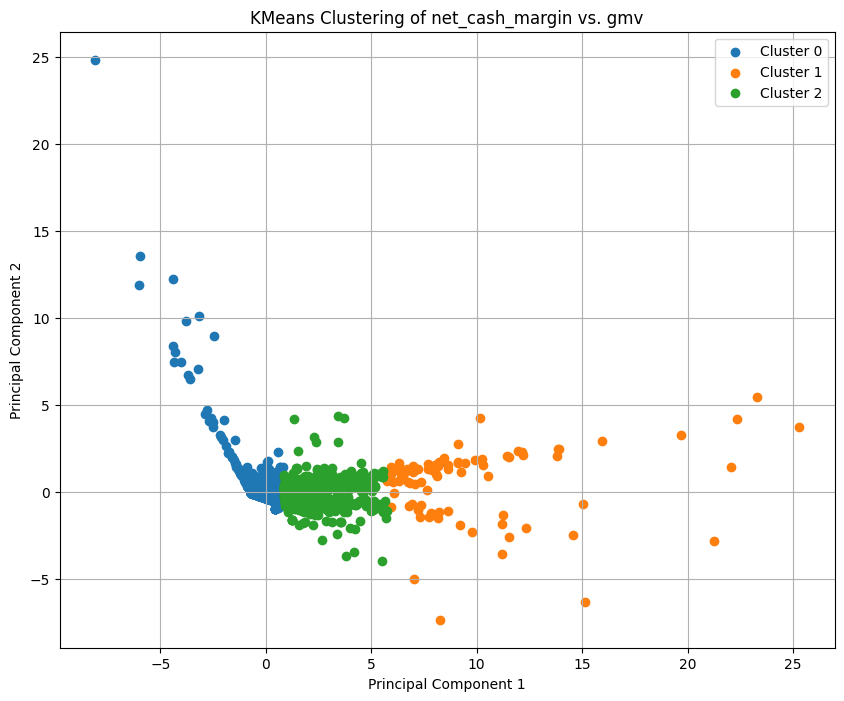

         net_cash_margin      gmv_usd
cluster                              
0               4.422223    53.096696
1             122.205012  1360.241638
2              34.009084   357.045687


In [90]:
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(df_pca[df['cluster'] == i, 0], df_pca[df['cluster'] == i, 1], label=f'Cluster {i}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering of net_cash_margin vs. gmv')
plt.legend()
plt.grid(True)
plt.show()

# You can further analyze the characteristics of each cluster
cluster_summary = df.groupby('cluster')[selected_columns].mean()
print(cluster_summary)

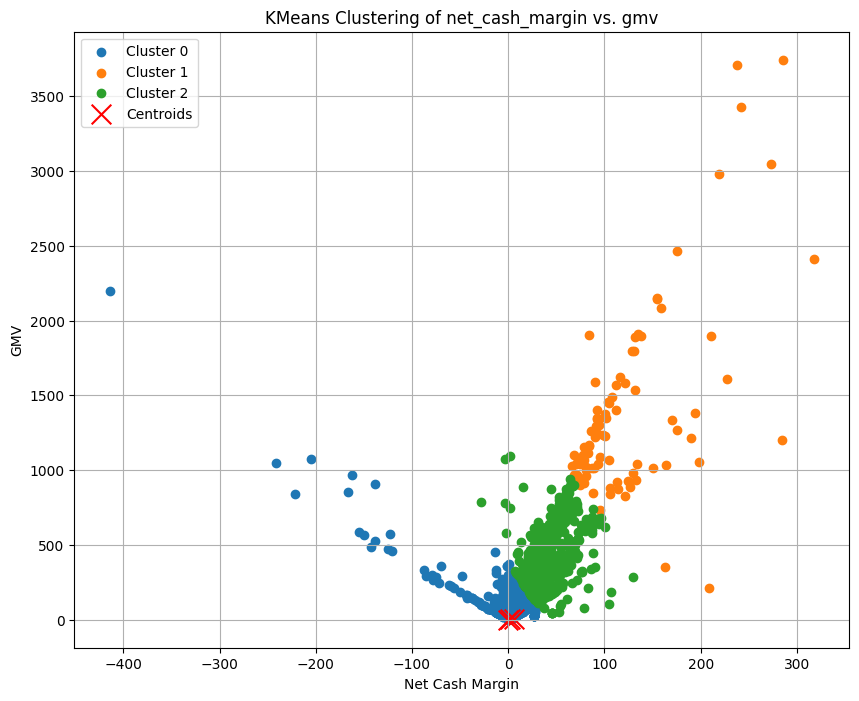

In [91]:
# Visualize the clusters without PCA
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(df['net_cash_margin'][df['cluster'] == i], df['gmv_usd'][df['cluster'] == i], label=f'Cluster {i}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='red', s=200, label='Centroids')
plt.xlabel('Net Cash Margin')
plt.ylabel('GMV')
plt.title('KMeans Clustering of net_cash_margin vs. gmv')
plt.legend()
plt.grid(True)
plt.show()